# RecordManager

In [1]:
import random
from torchhk.rm import RecordManager

## Init RecordManager

In [2]:
rm = RecordManager(['Epoch', 'Iter', 'loss_a', 'loss_b', 'train_acc', 'test_acc'])
rm

RecordManager(keys=[Epoch, Iter, loss_a, loss_b, train_acc, test_acc])

## Use RecordManager

In [3]:
for epoch in range(5):
    
    for i in range(2) :

        #########
        # Train #
        #########
        
        rm.progress()
        
        rm.add([epoch+1, i,
                random.random(), random.random(),
                90+random.random()*(epoch+1), 90+random.random()*(epoch+1)])

rm.summary()

--------------------------------------------------------
Epoch   Iter   loss_a   loss_b   train_acc   test_acc   
1       0      0.5122   0.8280   90.1486     90.2941    
--------------------------------------------------------
1       1      0.1822   0.4356   90.1765     90.3528    
--------------------------------------------------------
2       0      0.6448   0.4194   91.9486     90.3231    
--------------------------------------------------------
2       1      0.8943   0.9038   91.0642     91.4241    
--------------------------------------------------------
3       0      0.6358   0.7359   92.4341     90.5188    
--------------------------------------------------------
3       1      0.9082   0.7852   92.3704     92.4229    
--------------------------------------------------------
4       0      0.9486   0.1586   93.7000     91.9010    
--------------------------------------------------------
4       1      0.9043   0.4352   90.6886     92.4582    
-------------------------------

## Plot

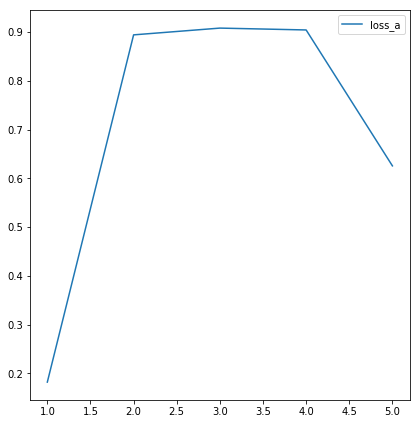

In [4]:
rm.plot('Epoch', 'loss_a')

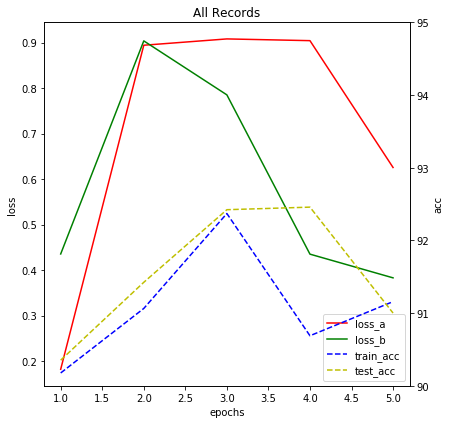

In [14]:
rm.plot('Epoch', [['loss_a', 'loss_b'], ['train_acc', 'test_acc']], 
        title="All Records", xlabel='epochs', ylabel="loss", ylabel_second="acc",
        ylim_second=(90,95),
        linestyles=['-', '-', '--', '--'],
        colors=['r', 'g', 'b', 'y'])